LIBRERIAS

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

DATOS

In [ ]:
# Datos
# ==============================================================================
datos = pd.read_csv('/content/meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Columns: 101 entries, V1 to fat
dtypes: float64(101)
memory usage: 169.8 KB


CORRELACIÓN

In [ ]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
1019,V11,V10,0.999996,0.999996
919,V10,V11,0.999996,0.999996
1021,V11,V12,0.999996,0.999996
1121,V12,V11,0.999996,0.999996
917,V10,V9,0.999996,0.999996


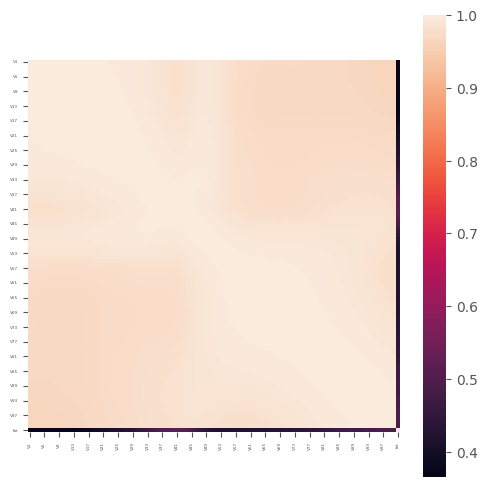

In [ ]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)

MODELOS

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

LinearRegression()

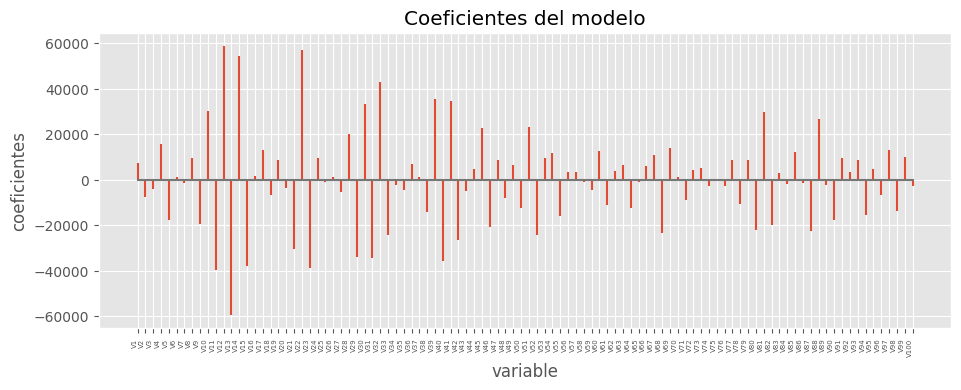

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([36.88226752, 62.47992661, 61.04825535,  9.95161352, 18.11993067,
        6.56158192, 28.42860453,  9.18085599, 15.56800749, 16.50461443])

In [ ]:
# Error de test del modelo
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.8396675855870854


RIDGE

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)

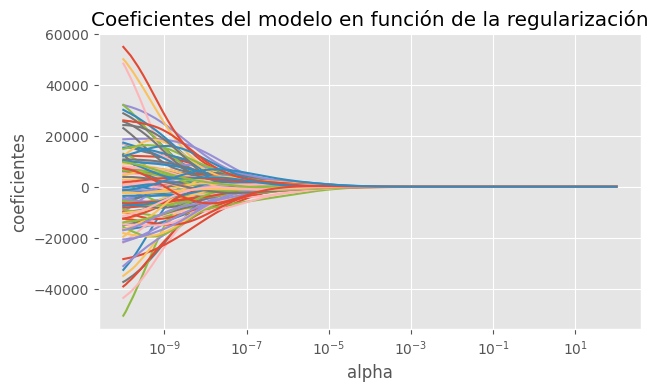

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

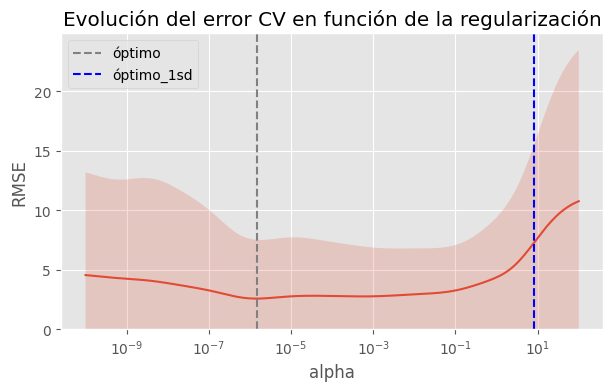

In [ ]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [ ]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.448118227674533e-06


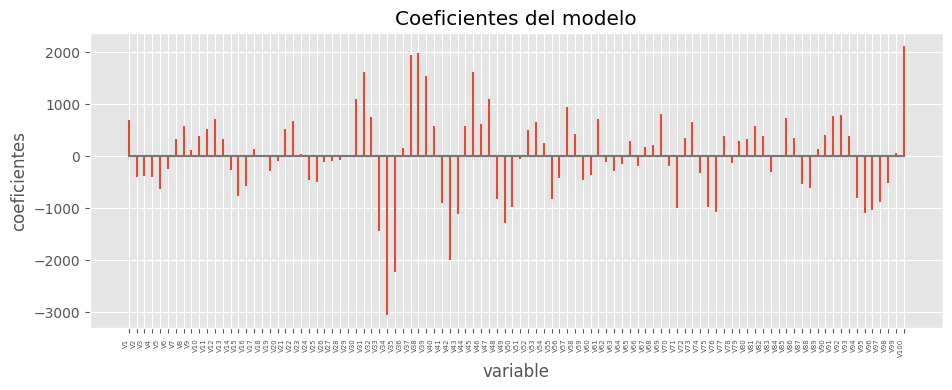

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([43.25153397, 40.41291904, 51.27092676,  9.93129675, 17.86636223,
        7.67420253, 28.12469153,  8.22086262, 14.79039287, 14.50322061])

In [ ]:
# Error de test del modelo
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 2.419595896650288


LASSO

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
modelo = LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

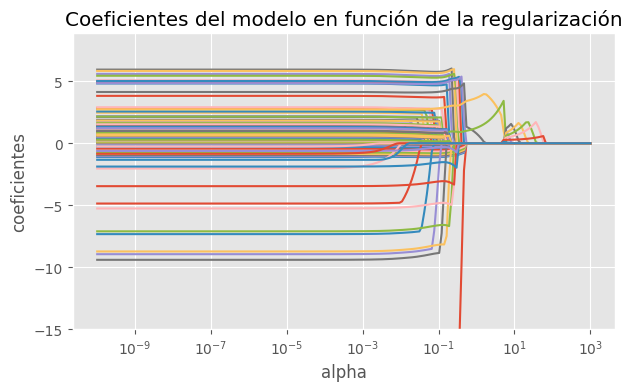

In [ ]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

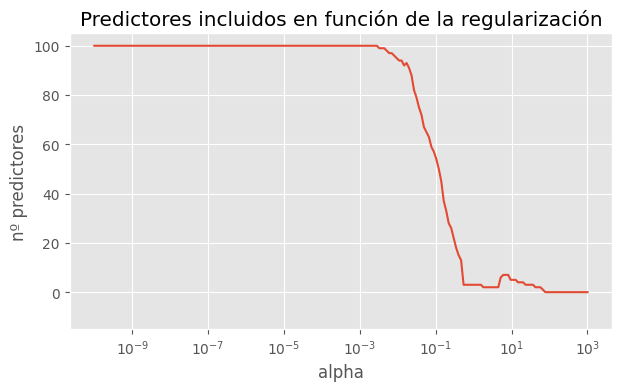

In [ ]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

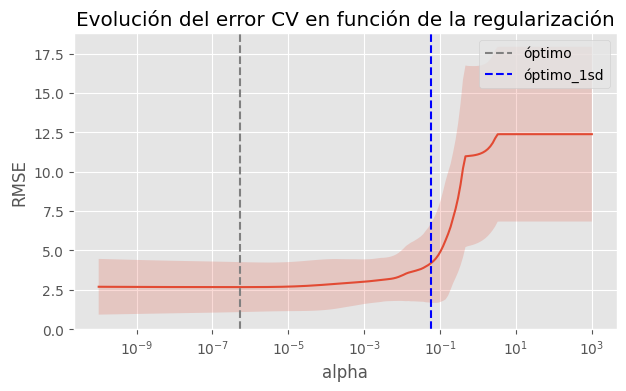

In [ ]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [ ]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 5.291978735958448e-07


In [ ]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.05672426]


In [ ]:
# Mejor modelo alpha óptimo + 1sd
# ==============================================================================
modelo = Lasso(alpha=optimo_1sd[0])
modelo.fit(X_train, y_train)

Lasso(alpha=0.05672426068491989)

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
7,V8,-5.440674
8,V9,-18.363079
9,V10,-15.986811
10,V11,-14.003453
11,V12,-12.001697
12,V13,-9.975379
13,V14,-7.840143
14,V15,-5.809662
15,V16,-3.983816
16,V17,-2.376551


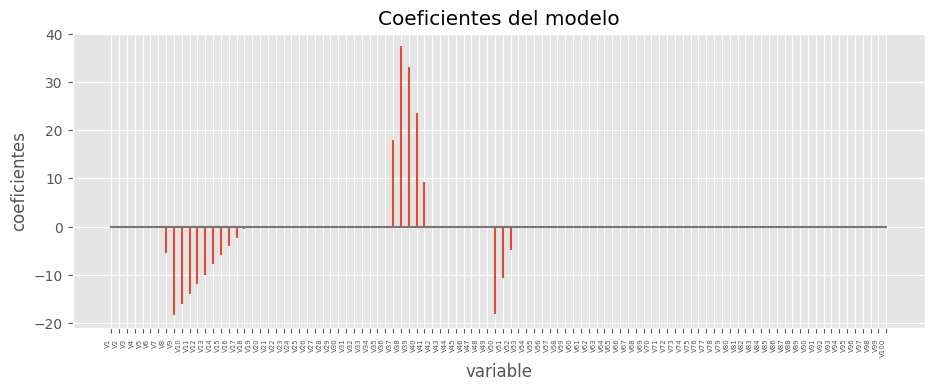

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Error de test del modelo
# ==============================================================================
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
             )
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 2.419595896650288


ELASTIC NET

In [ ]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
1341,0.99,6.150986e-07,7.125685,2.669398
1340,0.99,7.149429e-07,7.125726,2.669406
1342,0.99,5.291979e-07,7.125954,2.669448
1339,0.99,8.309942e-07,7.126149,2.669485
1343,0.99,4.552935e-07,7.126477,2.669546
...,...,...,...,...
419,0.50,5.738442e+01,153.287425,12.380930
837,0.90,3.827494e+00,153.287425,12.380930
836,0.90,4.448783e+00,153.287425,12.380930
808,0.90,3.001836e+02,153.287425,12.380930


In [ ]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [ ]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
# Error de test del modelo
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');